In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%pip install lightgbm
%pip install jinja2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

### Define research parameters

In [24]:
regression_task = False
# continuous_features = []
metric = 'accuracy'
test_size_proportion = 0.2
augment_sample = 0.5
metrics = ['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'] 

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]
name_mapping = {
    'random': 'Random',
    'smote': 'SMOTE',
    'cf_random': 'CF Random',
    'cf_genetic': 'CF Genetic',
}


In [25]:
from sklearn.datasets import make_classification

# Define the parameters of the synthetic dataset
n_samples = 600  # Total number of samples
n_features = 12   # Number of features
n_classes = 3    # Number of classes
class_weights = [0.5, 0.2, 0.3]  # Class imbalance ratio

# Create the imbalanced dataset
X, y = make_classification(n_samples=n_samples, 
                           n_features=n_features,
                           n_informative=3,
                           n_classes=n_classes,
                           n_clusters_per_class=2,
                           weights=class_weights,
                           class_sep=0.5, # 1
                           random_state=42)
X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
y = pd.Series(y, name="target")

In [26]:
continuous_features = X.columns.tolist()

#### split data

In [27]:
# all data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [28]:
display(y_train.value_counts())

0    250
2    142
1     88
Name: target, dtype: int64

In [29]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [30]:
print(f'whole adult dataset {metric} scores:')
whole_best_ests, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
whole_dataset_result_df



whole adult dataset accuracy scores:


,whole
,accuracy
lg,0.583333
rf,0.566667
xgb,0.616667


In [31]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### running experiments

In [32]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i} / {len(settings)}, {s}', end=' ')
    augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             cf_scoring = metric,
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
     utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # print(list(s.values())[0])

    full_results_df = pd.concat([full_results_df, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')
print(f'\nTotal time: {time.time() - total_time}')


0 / 4, {'method': 'random'} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

6.199785947799683 seconds for settings 0
1 / 4, {'method': 'smote'} 6.539610147476196 seconds for settings 1
2 / 4, {'method': 'cf_random'} model for cf accuracy score: {'cf': {'accuracy': 0.6}}
0/108


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


50/108


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


100/108


100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


0/162


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


50/162


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


100/162


100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


150/162


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


model for cf accuracy score: {'cf': {'accuracy': 0.6}}
0/240


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


50/240


100%|██████████| 1/1 [00:00<00:00, 11.74it/s]


100/240


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


150/240


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


200/240


100%|██████████| 1/1 [00:00<00:00, 11.51it/s]


272.61593294143677 seconds for settings 2
3 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf accuracy score: {'cf': {'accuracy': 0.6}}
0/108


100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


50/108


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


100/108


100%|██████████| 1/1 [00:00<00:00, 18.28it/s]


0/162


100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


50/162


100%|██████████| 1/1 [00:00<00:00, 18.53it/s]


100/162


100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


150/162


100%|██████████| 1/1 [00:00<00:00, 18.66it/s]


model for cf accuracy score: {'cf': {'accuracy': 0.6}}
0/240


100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


50/240


100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


100/240


100%|██████████| 1/1 [00:00<00:00, 18.75it/s]


150/240


100%|██████████| 1/1 [00:00<00:00, 18.81it/s]


200/240


100%|██████████| 1/1 [00:00<00:00, 18.88it/s]
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

169.51272702217102 seconds for settings 3

Total time: 454.868693113327


In [33]:
full_results_df

whole      random                                                 \
     accuracy f1_weighted  accuracy balanced_accuracy precision_weighted   
lg   0.583333    0.502033  0.583333          0.508333           0.468042   
rf   0.566667    0.518568  0.575000          0.504444           0.647908   
xgb  0.616667    0.620810  0.625000          0.602222           0.632371   

                                                                    smote  \
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted   
lg         0.583333             0.709737             0.700104    0.535022   
rf         0.575000             0.758631             0.753972    0.584567   
xgb        0.625000             0.777409             0.776844    0.583607   

               ...       cf_random                                            \
     accuracy  ... recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted   
lg   0.533333  ...        0.541667             0.735865             0.728493   
rf   0.583333  ...        0.591667             0.743953             0.736306   
xgb  0.583333  ...        0.616667             0.781300             0.780875   

     cf_genetic                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.517778  0.600000          0.525000           0.477731   
rf     0.559882  0.608333          0.547778           0.702412   
xgb    0.639195  0.641667          0.622778           0.654708   

                                                               
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted  
lg         0.600000             0.696093             0.686722  
rf         0.608333             0.766832             0.760885  
xgb        0.641667             0.758644             0.778531  

[3 rows x 29 columns]

In [34]:
print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    max_models = models_scores.idxmax(axis='columns')
    max_models.name = s
    max_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)
    best_methods = pd.concat([best_methods, max_models], axis=1)
best_methods

best methods


,f1_weighted,accuracy,balanced_accuracy,precision_weighted,recall_weighted,roc_auc_ovr_weighted,roc_auc_ovo_weighted
lg,cf_random,cf_genetic,cf_random,cf_random,cf_genetic,cf_random,cf_random
rf,cf_random,cf_genetic,smote,cf_genetic,cf_genetic,cf_genetic,smote
xgb,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_random,cf_random
overall,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_genetic,cf_random,cf_random


In [35]:
full_results_df.to_csv(rf'../log/experiment_multiclass_artifical.csv')

In [36]:
print('Methods and their scores')
methods_scores = {}
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    methods_scores[s] = models_scores

Methods and their scores


In [43]:
float_format = "{:0.4f}".format

for metric, df in methods_scores.items():
    latex = df.to_latex(float_format=float_format, index=False)
    latex = latex.replace('\\toprule', '').replace('\\midrule', '').replace('\\bottomrule', '')
    latex = latex.split('\n')
    latex.insert(1, '\\toprule')
    latex.insert(4, '\\midrule')
    latex.insert(-2, '\\bottomrule')
    latex = '\n'.join(latex)

    
    # Write the LaTeX table to a file
    with open(f'../graphs/artifical/latex/artifical_{metric}_table.tex', 'w') as f:
        f.write(latex)

/var/folders/vk/hzbp84pd4xj2yyb43dry8k340000gn/T/ipykernel_72780/2592047062.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(float_format=float_format, index=False)


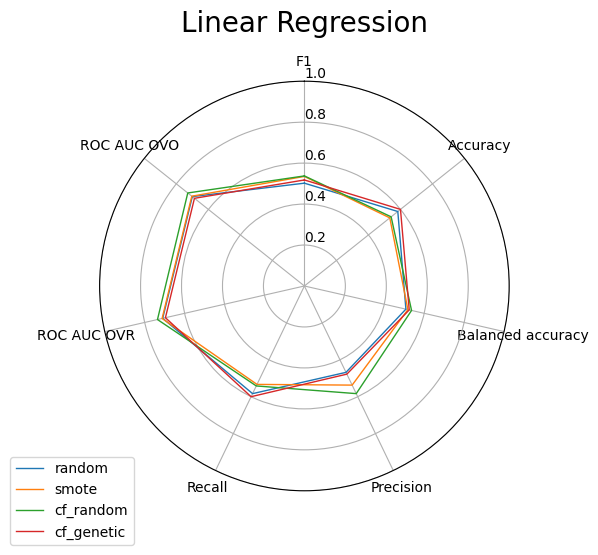

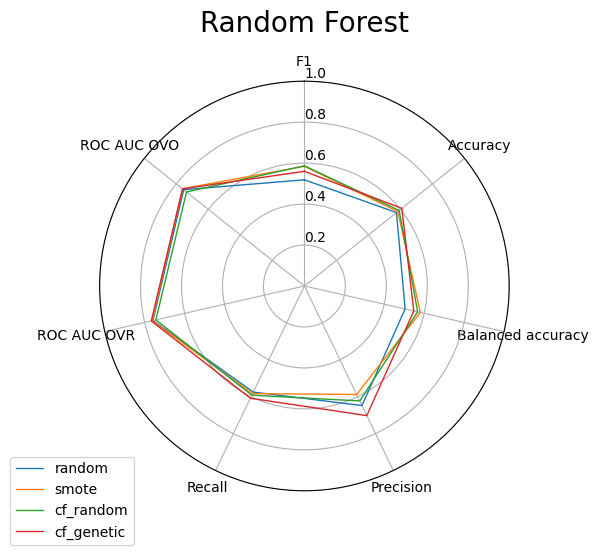

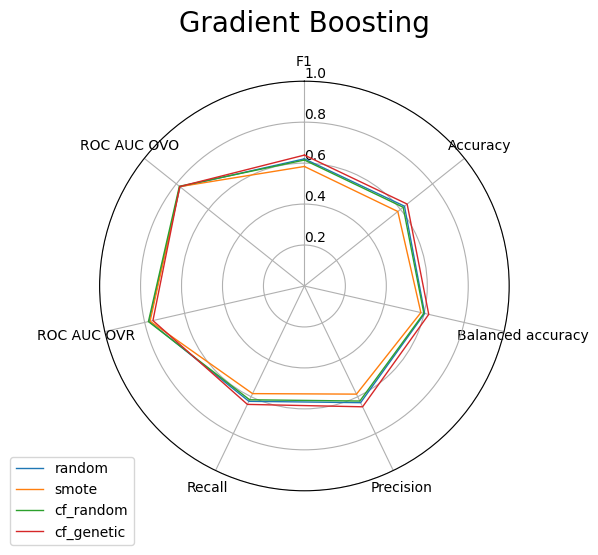

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
wanted_cols = ['random','smote','cf_random','cf_genetic']
metric_names = ['F1', 'Accuracy', 'Balanced accuracy', 'Precision', 'Recall','ROC AUC OVR','ROC AUC OVO']  

num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]
def plot_spider(df, idx=0, title='Spider plot'):
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Makes sure the First metric is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metric_names)
    ax.set_rlabel_position(0)
    plt.ylim(0, 1)
    # print(df.iloc[0])
    values = []
    labels = df.columns
    for _, df in methods_scores.items(): 
        df2 = df[wanted_cols]
        values.append(df2.iloc[idx])
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=wanted_cols)
    # ax.fill(angles,values, alpha=0.1)


    # Add legend
    plt.title(title, size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../graphs/artifical/{title}.png')

plot_spider(df, idx=0, title='Linear Regression')
plot_spider(df, idx=1, title='Random Forest')
plot_spider(df, idx=2, title='Gradient Boosting')